## Spec2Struct Demo

Running this code assumes that you have a CUDA compatible device

### Import packages and define functions


In [10]:
import numpy as np
import pandas as pd
import torch
from loguru import logger
from run_ga import compute_individual_atom_counts, cosine_similarity, gpu_encode_smiles, load_models


def cnmr_to_vector(nmr_shifts):
    init_vec = torch.zeros(512, dtype=torch.float32)
    for shift in nmr_shifts:
        index = int(shift / 300 * 512)
        init_vec[index] = 1
    return init_vec


def reward_function_molecular_formula(
    individuals: list[str],
    ir_model: torch.nn.Module,
    cnmr_model: torch.nn.Module,
    hnmr_model: torch.nn.Module,
    atom_counts_original_smiles: dict,
    spectra_cnmr_embedding: str,
    spectra_ir_embedding: str,
    spectra_hnmr_embedding: str,
):
    ir_embedding, cnmr_embedding, hnmr_embedding = gpu_encode_smiles(individuals, ir_model, cnmr_model, hnmr_model)
    # count individual atom types
    molecular_formula_loss = np.zeros(len(individuals))
    nr_of_atoms_in_original_smiles = sum(atom_counts_original_smiles.values())

    for individual_idx, individual in enumerate(individuals):
        atom_counts_individual = compute_individual_atom_counts(individual)
        molecular_formula_loss_per_individual = 0
        if atom_counts_individual is None:
            continue
        # calculate the difference in atom counts
        for atom, count in atom_counts_individual.items():
            molecular_formula_loss_per_individual += abs(count - atom_counts_original_smiles.get(atom, 0))
        molecular_formula_loss[individual_idx] = -molecular_formula_loss_per_individual / nr_of_atoms_in_original_smiles
    ir_cosine_similarity = cosine_similarity(ir_embedding, spectra_ir_embedding, dim=1).detach().cpu().numpy()
    cnmr_cosine_similarity = cosine_similarity(cnmr_embedding, spectra_cnmr_embedding, dim=1).detach().cpu().numpy()
    hnmr_cosine_similarity = cosine_similarity(hnmr_embedding, spectra_hnmr_embedding, dim=1).detach().cpu().numpy()
    sum_cosine_similarity = ir_cosine_similarity + cnmr_cosine_similarity + hnmr_cosine_similarity
    # concattenated_spectra_embeddings = torch.cat([ir_embedding, cnmr_embedding, hnmr_embedding], dim=1)
    # concattenated_smiles_embeddings = torch.cat([spectra_ir_embedding, spectra_cnmr_embedding, spectra_hnmr_embedding], dim=0)
    # sum_cosine_similarity = cosine_similarity(concattenated_spectra_embeddings, concattenated_smiles_embeddings, dim=1).cpu().numpy()
    return sum_cosine_similarity / 3 + molecular_formula_loss


### Define models and compute spectra embeddings

In [11]:
# Load the data
data = pd.read_parquet("../../data/simulated_spectra_test_set.parquet")

# preprocess the data
INDEX_TEST = 3
# IR is in the range 200 - 3800 cm-1
ir = torch.tensor(data.ir[INDEX_TEST][100:1700]).unsqueeze(0).unsqueeze(0).float().to("cuda")
# 1H NMR is in the range -2 to 10 ppm
hnmr = torch.tensor(data.h_nmr[INDEX_TEST]).unsqueeze(0).unsqueeze(0).float().to("cuda")
# 13C NMR is in the range 0 - 300 ppm
cnmr = cnmr_to_vector(data.c_nmr[INDEX_TEST]).unsqueeze(0).to("cuda")
smiles = data.smiles[INDEX_TEST]
# Define SMILES embedding model

ir_experiment = "metrics/ir_simulated_large_dataset_testset"
cnmr_experiment = "metrics/cnmr_simulated_large_dataset_testset"
hnmr_experiment = "metrics/hnmr_cnn_detailed_large_dataset"
ir_model, cnmr_model, hnmr_model = load_models(
    "../../configs",
    ir_experiment=ir_experiment,
    cnmr_experiment=cnmr_experiment,
    hnmr_experiment=hnmr_experiment,
)

ir_encoding = ir_model.encode_modality(ir, modality="ir")
cnmr_encoding = cnmr_model.encode_modality(cnmr, modality="c_nmr")
hnmr_encoding = hnmr_model.encode_modality(hnmr, modality="h_nmr_cnn")

2025-01-12 12:10:22.811 | INFO     | molbind.models.model:__init__:17 - Non-central modalities: ['ir']
2025-01-12 12:10:22.813 | INFO     | molbind.models.components.custom_encoders:__init__:667 - {'length_in': 1600, 'channels_in': 1, 'channels_out_1': 45, 'channels_out_2': 45, 'channels_out_3': 90, 'channels_out_4': 90, 'latent_dim': 512, 'num_conv_layers': 3, 'num_fc_layers': 2, 'conv_kernel_dim_1': 10, 'conv_stride_1': 1, 'conv_padding_1': 0, 'conv_dilation': 1, 'pool_kernel_dim_1': 5, 'pool_stride_1': 5, 'pool_padding_1': 0, 'pool_dilation': 1, 'conv_kernel_dim_2': 5, 'conv_stride_2': 1, 'conv_padding_2': 0, 'pool_kernel_dim_2': 3, 'pool_stride_2': 2, 'pool_padding_2': 0, 'conv_kernel_dim_3': 5, 'conv_stride_3': 1, 'conv_padding_3': 0, 'pool_kernel_dim_3': 2, 'pool_stride_3': 1, 'pool_padding_3': 0, 'fc_dim_1': 512, 'fc_dim_2': 512, 'conv_kernel_dim_4': 4, 'conv_stride_4': 1}
2025-01-12 12:10:23.632 | INFO     | molbind.models.model:__init__:17 - Non-central modalities: ['c_nmr']
2

### Obtain similar compounds from PubChem (based on the molecular formula)

For this DEMO we exclude the correct SMILES from the PubChem Database

In [12]:
from functools import partial

import polars as pl
from generate_molformula_files import (
    gen_close_molformulas_from_seed,
    tanimoto_similarity,
)
from request_pubchem import read_cached_CID_smiles, smiles_to_molecular_formula

molecular_formula = smiles_to_molecular_formula(smiles)
# read the cached PubChem data
data = read_cached_CID_smiles()
molecular_formulas = gen_close_molformulas_from_seed(seed_formula=molecular_formula)
# filter the polar compounds by the molecular formulas
filtered_data = data.filter(data["molecular_formula"].is_in(molecular_formulas))
filtered_data = filtered_data.with_columns(
    pl.col("smiles")
    .map_elements(partial(tanimoto_similarity, smiles2=smiles), return_dtype=pl.Float32)
    .alias("tanimoto_similarity")
)
filtered_data = filtered_data.filter(filtered_data["tanimoto_similarity"] != 1)
# Get the list of similar smiles
list_of_similar_smiles = filtered_data["smiles"].to_list()

### Embed all SMILES via the specific model

We generate SMILES embeddings for database molecules, and then use the top `N` as initial population for the `GraphGA` genetic algorithm.

In [13]:
ir_embeddings, cnmr_embeddings, hnmr_embeddings = gpu_encode_smiles(
    list_of_similar_smiles, ir_model=ir_model, cnmr_model=cnmr_model, hnmr_model=hnmr_model
)

100%|██████████| 2/2 [00:25<00:00, 12.57s/it]


In [14]:
# compute the cosine similarity between the original spectra and the similar smiles
ir_similarity = cosine_similarity(ir_encoding, ir_embeddings).detach().cpu().numpy()
cnmr_similarity = cosine_similarity(cnmr_encoding, cnmr_embeddings).detach().cpu().numpy()
hnmr_similarity = cosine_similarity(hnmr_encoding, hnmr_embeddings).detach().cpu().numpy()

similarity_sum = ir_similarity + cnmr_similarity + hnmr_similarity
# top-256
top_256_indices = np.argsort(similarity_sum)[::-1][:256]
top_256_smiles = [list_of_similar_smiles[i] for i in top_256_indices]

In [15]:
# Define the scoring function
from random import Random

from gafuncs import CachedBatchFunction
from mol_ga import default_ga
from mol_ga.graph_ga.gen_candidates import graph_ga_blended_generation

rng = Random(999)
number_of_generations = 10
init_reward = partial(
    reward_function_molecular_formula,
    ir_model=ir_model,
    cnmr_model=cnmr_model,
    hnmr_model=hnmr_model,
    atom_counts_original_smiles=compute_individual_atom_counts(smiles),
    spectra_cnmr_embedding=cnmr_encoding,
    spectra_ir_embedding=ir_encoding,
    spectra_hnmr_embedding=hnmr_encoding,
)
ga_results = default_ga(
    starting_population_smiles=top_256_smiles,
    scoring_function=CachedBatchFunction(init_reward),
    max_generations=number_of_generations,
    offspring_size=1024,
    population_size=256,
    logger=logger,
    rng=rng,
    offspring_gen_func=partial(graph_ga_blended_generation, frac_graph_ga_mutate=0.1),
)

2025-01-12 12:11:02.250 | INFO     | mol_ga.general_ga:run_ga_maximization:73 - Starting GA maximization...
2025-01-12 12:11:02.251 | DEBUG    | mol_ga.general_ga:run_ga_maximization:83 - Starting cache made, has size 0
100%|██████████| 1/1 [00:00<00:00,  1.24it/s]
2025-01-12 12:11:03.088 | INFO     | gafuncs:_batch_f_eval:57 - Best smiles: (0.6137709617614746, 'CCOC(=O)C(C)(C)SC(=O)C(C)C')
2025-01-12 12:11:03.089 | DEBUG    | mol_ga.general_ga:run_ga_maximization:93 - Initial population scoring done. Pop size=256, Max=0.6137709617614746
2025-01-12 12:11:03.089 | INFO     | mol_ga.general_ga:run_ga_maximization:107 - Start generation 0
2025-01-12 12:11:03.808 | DEBUG    | mol_ga.general_ga:run_ga_maximization:125 - 	715 created
2025-01-12 12:11:03.809 | DEBUG    | mol_ga.general_ga:run_ga_maximization:126 - 	New population size = 958
2025-01-12 12:11:03.809 | DEBUG    | mol_ga.general_ga:run_ga_maximization:130 - 	Calling scoring function...
100%|██████████| 1/1 [00:02<00:00,  2.10s/it

In [16]:
print(f"Correct SMILES: {smiles} \nBest GA SMILES: {ga_results.population[0][1]}")

Correct SMILES: CC(=O)SC(C)C(C)C(=O)OC(C)C 
Best GA SMILES: CC(=O)SC(C)C(C)C(=O)OC(C)C


### Test interpolation

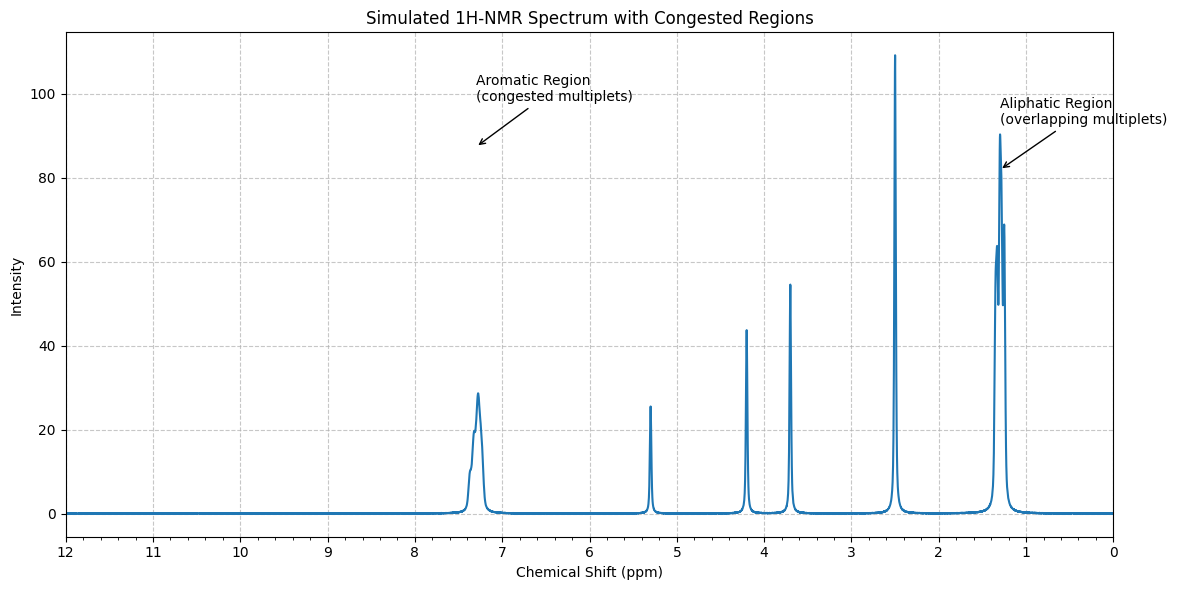